# PID Classification with Neural Networks

This example illustrates the classification of particle types using tensorflow/keras neural networks. The supervised training uses labeled MC generated data from BaBar.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import uproot

1.13.1


# Training Data
We are reading the training data from a ROOT file. The file contains particle momentum (mom) and track elevation (theta), dE/dx measurement from silicon vertex tracker (svt) and drift chamber (dch), as well as energy deposit in the electromagnetic calorimeter (emc), the cerenkov angle in the DIRC (drc), and the hit patterns in the instrumented flux return (ifr). The file in addition holds higher level features like partial energy sums, zernicke momenta, likelihood etc. 

The particles are labeled (id)
* Electron = 0
* Muon = 1
* Pion = 2
* Kaon = 3
* Proton = 4

In [2]:
file = uproot.open("pid.root")

In [3]:
file.keys()

[b'PidTuple;1']

In [4]:
tree = file["PidTuple"]
tree.keys()

[b'mom',
 b'theta',
 b'svt',
 b'emc',
 b'drc',
 b'dch',
 b'ifr',
 b'ifrExp',
 b'ifrAdd',
 b'ifrStrip',
 b'ifrFirst',
 b'ifrLast',
 b'emcS1S9',
 b'emcS9S25',
 b'emczern20',
 b'emczern40',
 b'emclat',
 b'charge',
 b'drcnphot',
 b'emcphi',
 b'emctheta',
 b'pid',
 b'lipisvt',
 b'limusvt',
 b'likasvt',
 b'lipidch',
 b'limudch',
 b'likadch',
 b'lipidrc',
 b'limudrc',
 b'likadrc',
 b'lipiemc',
 b'limuemc',
 b'likaemc',
 b'lipiifr',
 b'limuifr',
 b'likaifr',
 b'charge',
 b'id']

In [5]:
tree.numentries

83826

We assemble the training dataset as a pandas dataframe and plot the particle statistics:

In [6]:
data = tree.arrays(["id", "mom", "theta", "svt", "emc", "drc", "dch", "ifr"])
dataset = pd.DataFrame(data)
dataset.tail()

,b'id',b'mom',b'theta',b'svt',b'emc',b'drc',b'dch',b'ifr'
83821,4,1.156832,0.842868,5.810547,0.365639,0.495674,732.421875,0.000000
83822,4,2.320551,0.914929,4.296875,1.259613,0.749020,537.109375,0.000000
83823,4,1.881898,0.807030,4.589844,0.164413,0.710582,454.101562,2.352941
83824,4,1.998565,0.996907,3.564453,0.463104,0.721126,444.335938,3.019608
83825,4,0.995329,0.923367,6.005859,0.354385,0.364935,771.484375,0.000000


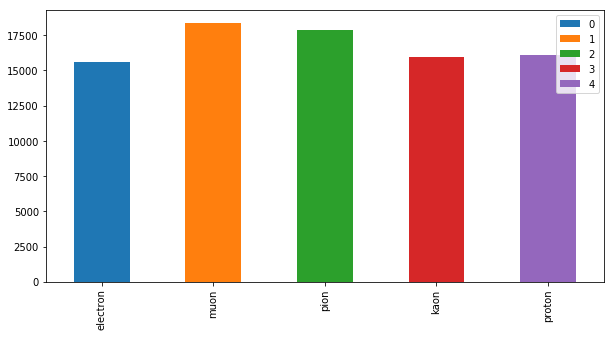

In [7]:
electron = dataset[dataset[b'id']==0][b'id'].value_counts()
muon = dataset[dataset[b'id']==1][b'id'].value_counts()
pion = dataset[dataset[b'id']==2][b'id'].value_counts()
kaon = dataset[dataset[b'id']==3][b'id'].value_counts()
proton = dataset[dataset[b'id']==4][b'id'].value_counts()

df = pd.DataFrame([electron, muon, pion, kaon, proton])
df.index = ['electron','muon','pion','kaon','proton']
df.plot(kind='bar',stacked=True, figsize=(10,5))

# Data Preparation
We generate a training dataset (80%) and a test dataset (20%) from the input dataset. The vectors are shuffled in random order.

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.head()

,b'id',b'mom',b'theta',b'svt',b'emc',b'drc',b'dch',b'ifr'
16513,1,2.303902,0.963000,3.173828,0.214386,0.820661,571.289062,4.745098
71045,4,0.821490,0.799382,7.812500,1.312256,0.000000,1064.453125,0.000000
26753,1,2.172990,0.908513,2.661133,0.200272,0.821332,600.585938,5.294117
62312,3,0.615907,0.625079,0.000000,0.353432,0.000000,742.187500,0.000000
65912,3,0.824803,0.747739,4.785156,0.215530,0.646815,512.695312,1.254902


Show a correlation matrix of the feature vector:

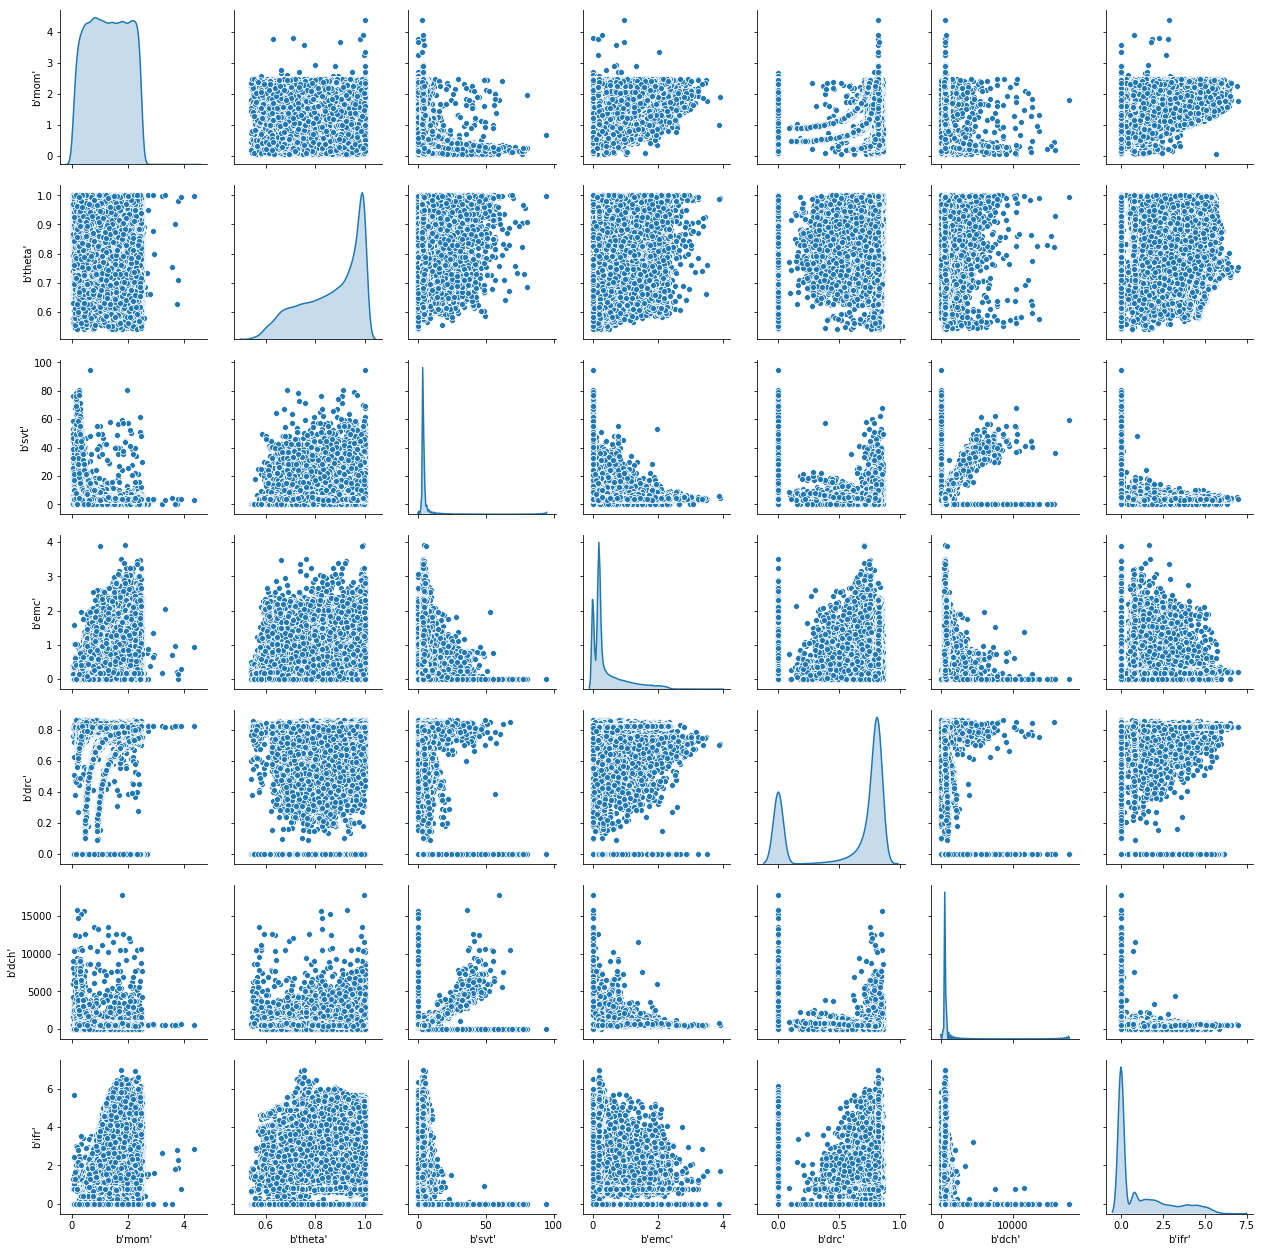

In [9]:
sns.pairplot(train_dataset[[b'mom', b'theta', b'svt', b'emc', b'drc', b'dch', b'ifr']], diag_kind="kde")
plt.show()

We extract the particle labels to be used with supervised training:

In [10]:
train_labels = train_dataset.pop(b'id')
test_labels = test_dataset.pop(b'id')

We normalize the training and test vectors:

In [11]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
b'mom',67061.0,1.307108,0.689137,0.050066,0.720330,1.304925,1.901470,4.373626
b'theta',67061.0,0.868312,0.117698,0.540726,0.778278,0.900298,0.974814,1.000000
b'svt',67061.0,4.892804,5.299843,0.000000,3.320312,3.759766,4.492188,94.531250
b'emc',67061.0,0.436656,0.535124,0.000000,0.150967,0.203514,0.564957,3.915405
b'drc',67061.0,0.571136,0.351391,0.000000,0.000000,0.792264,0.820829,0.864134
b'dch',67061.0,605.618286,578.292175,0.000000,473.632812,537.109375,634.765625,17812.500000
b'ifr',67061.0,1.168364,1.622137,0.000000,0.000000,0.000000,2.039216,6.980392


In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Training Model
The keras model implements a neural network with two hidden layers. The input feature vector represents measured detector quantities as defined above. The output reflects the particle probabilities.

In [13]:
def build_model():
    model = keras.Sequential([
    layers.Dense(25, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(5, activation=tf.nn.softmax)
  ])

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [14]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 515
Trainable params: 515
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 10

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


..........

## Model Evaluation
We evaluate the model performance using the mormalized test data set and compare the output vector to the test labels. 

In [17]:
test_loss, test_acc = model.evaluate(normed_test_data, test_labels)

16765/16765 [==============================] - 0s 12us/sample - loss: 0.4487 - acc: 0.8486


In [18]:
predictions = model.predict(normed_test_data)
predictions

array([[9.9358445e-01, 6.0497172e-08, 7.4858376e-04, 9.8067321e-05,
        5.5688410e-03],
       [9.9997711e-01, 5.8074883e-14, 3.0882092e-07, 6.1073751e-09,
        2.2589191e-05],
       [5.8814102e-01, 6.7249276e-02, 2.9454064e-01, 2.2389056e-02,
        2.7680062e-02],
       ...,
       [4.3362899e-08, 1.8424838e-06, 6.9350115e-04, 6.7762591e-02,
        9.3154204e-01],
       [2.8408794e-19, 5.8177480e-10, 2.3923256e-02, 5.7540298e-02,
        9.1853648e-01],
       [1.8756347e-03, 6.3079783e-06, 3.4555786e-05, 5.9787566e-03,
        9.9210477e-01]], dtype=float32)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
pred_labels = np.argmax(predictions, axis=1)
print(confusion_matrix(test_labels, pred_labels))

[[2733   85  143   78   75]
 [  78 3131  426   45   14]
 [  55  541 2614  233   93]
 [  18   50  189 2786   96]
 [  56   36   89  139 2962]]


Generate a summary report:

In [20]:
target_names = ['Electron', 'Muon', 'Pion', 'Kaon', 'Proton']
print(classification_report(test_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

    Electron       0.93      0.88      0.90      3114
        Muon       0.81      0.85      0.83      3694
        Pion       0.76      0.74      0.75      3536
        Kaon       0.85      0.89      0.87      3139
      Proton       0.91      0.90      0.91      3282

   micro avg       0.85      0.85      0.85     16765
   macro avg       0.85      0.85      0.85     16765
weighted avg       0.85      0.85      0.85     16765



## Training History
We produce some control plots from the Keras history. 

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,acc,val_loss,val_acc,epoch
0,1.048601,0.566247,0.870604,0.655036,0
1,0.776680,0.711397,0.670331,0.756356,1
2,0.625358,0.783589,0.568709,0.800045,2
3,0.556344,0.811978,0.521640,0.823231,3
4,0.522552,0.825492,0.499078,0.832178,4
5,0.501418,0.831811,0.485780,0.833892,5
6,0.484477,0.836956,0.473435,0.840379,6
7,0.471661,0.840124,0.459855,0.841944,7
8,0.462026,0.841989,0.459086,0.841124,8
9,0.454120,0.843890,0.448708,0.845523,9


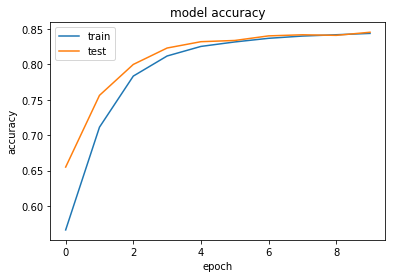

In [22]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

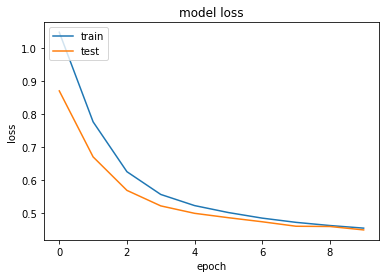

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()